Libraries required: gym, numpy, matplotlib, random

In [1]:
!pip install gym

You should consider upgrading via the '/Users/feixiao/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
import random
import time

ModuleNotFoundError: No module named 'numpy'

In [237]:
class GridEnvironment(gym.Env):
    
    def __init__(self):
        self.row = 4
        self.col = 4
        self.observation_space = spaces.Discrete(self.row * self.col)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 200
    
    def reset(self):
        self.timestep = 0
        self.agent_pos = [0,0]
        self.goal_pos = [self.row-1,self.col-1]
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.robbery_pos = [(0, 2), (1, 1)]
        for pos in self.robbery_pos:
            self.state[pos] = 0.3
        self.dollar_pos = [(2, 0), (2, 3)]
        for pos in self.dollar_pos:
            self.state[pos] = 0.7
        self.state[tuple(self.goal_pos)] = 0.5
        observation = self.state.flatten()
        return observation
    
    def step(self, action):
        old_pos = self.agent_pos.copy()
        
        if action ==0: #down
            self.agent_pos[0] +=1  #[0,1]->[1,1]
        if action ==1: #up
            self.agent_pos[0] -=1  #[1,1]->[0,1]
        if action ==2: #right
            self.agent_pos[1] +=1
        if action ==3: #left
            self.agent_pos[1] -=1    
        
        self.agent_pos = np.clip(self.agent_pos, 0, 3)
       
        reward = 0
        if (self.agent_pos == self.goal_pos).all():
            reward = 10
        elif self.state[tuple(self.agent_pos)] == 0.7:
            reward = 4
        elif self.state[tuple(self.agent_pos)] == 0.3:
            reward = -5

        self.state[tuple(old_pos)] = 0
        self.state[tuple(self.agent_pos)] = 1
        observation = self.state.flatten()
        self.timestep += 1
        done = True if self.timestep>= self.max_timesteps or (self.agent_pos == self.goal_pos).all() else False
        info = {}
        
        return observation, reward, done, info
    
    
    def render(self):
        plt.imshow(self.state)
        plt.show(block=True)

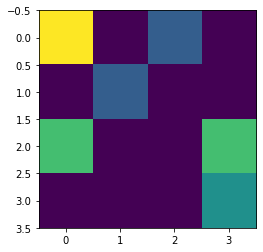

In [238]:
env = GridEnvironment()
obs = env.reset()
env.render()

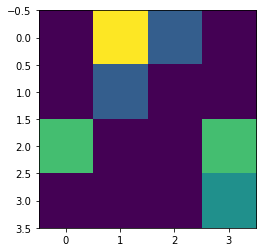

In [239]:
action = 2
observation, reward, done, info = env.step(action)
env.render()

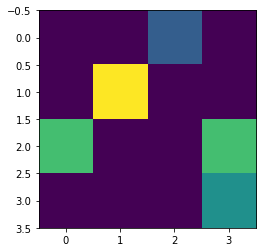

In [240]:
action = 0
observation, reward, done, info = env.step(action)
env.render()

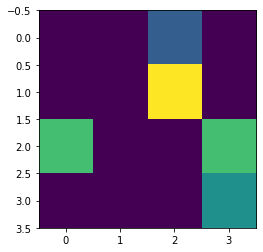

In [241]:
action = 2
observation, reward, done, info = env.step(action)
env.render()

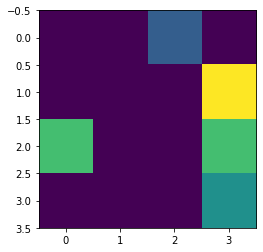

In [242]:
action = 2
observation, reward, done, info = env.step(action)
env.render()

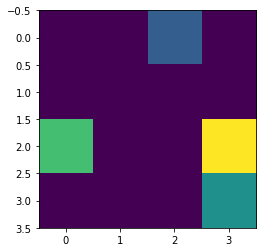

In [243]:
action = 0
observation, reward, done, info = env.step(action)
env.render()

In [244]:
print('Reward:', reward)

Reward: 4


## Random Agent

In [245]:
class RandomAgent:
    '''Random Agent class that contains the contains the information of the agent that takes action randomly'''
    def __init__(self, env):
        self.env = env
        self.observation_space = env.observation_space
        self.action_space = env.action_space

    def step(self, observation):
        return np.random.choice(self.action_space.n)

Action 1
Reward 0
Done False



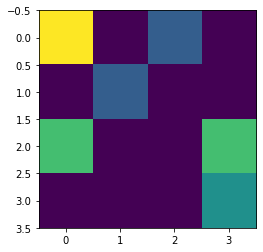

Action 2
Reward 0
Done False



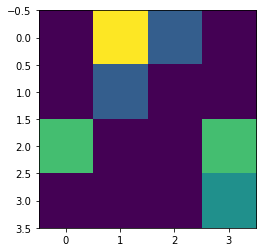

Action 3
Reward 0
Done False



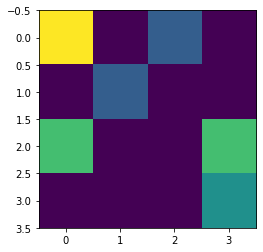

Action 0
Reward 0
Done False



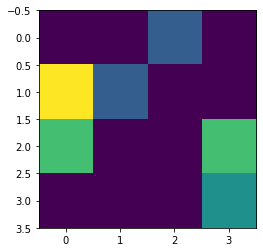

Action 3
Reward 0
Done False



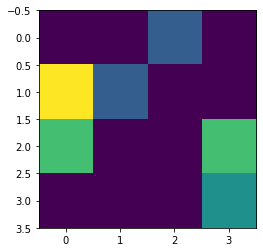

Action 0
Reward 4
Done False



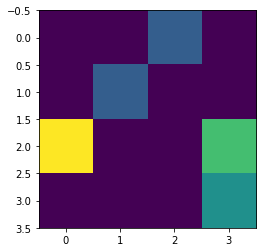

Action 1
Reward 0
Done False



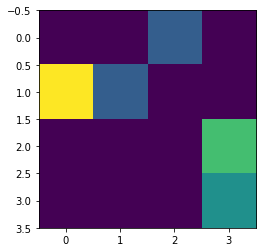

Action 3
Reward 0
Done False



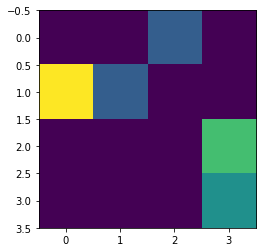

Action 2
Reward -5
Done False



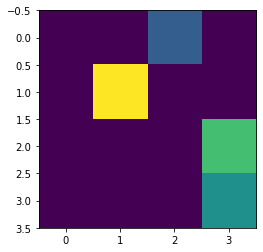

Action 1
Reward 0
Done False



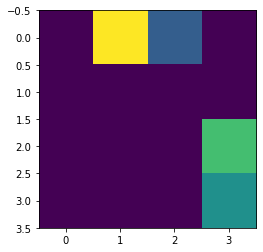

In [246]:
# Random Agent
# Create Environment
env = GridEnvironment()

# Create random agent
agent = RandomAgent(env)
obs = env.reset()
done = False

# Repeat steps of Agent till Episode ends
# 0 - Right, 1 - Left, 2 - Up, 3 - Down
for i in range(10):
    action = agent.step(obs)
    obs, reward, done, _ = env.step(action)
    
    print('Action', action)
    print('Reward', reward)
    print('Done', done)
    print()
    env.render()
    if done:
        break
    time.sleep(1)

0 -> Down <br>
1 -> Up <br>
2 -> Right <br>
3 -> Left

# 2. SARSA Algorithm

In [275]:
def SARSA_solver(min_epsilon, max_epsilon, decay_rate, total_episodes, max_steps, lr_rate, gamma):
    env = GridEnvironment()
    agent = RandomAgent(env)
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []
    epsilon = max_epsilon
    for episode in range(total_episodes):
        obs = env.reset()
        pos = np.where(obs == 1)[0][0]
        action = agent.step(obs) if np.random.uniform(0, 1) < epsilon else np.argmax(Q[pos, :])
        total_rewards = 0
        for step in range(max_steps):
            obs2, reward, done, _ = env.step(action)
            pos2 = np.where(obs2 == 1)[0][0]
            action2 = agent.step(obs2) if np.random.uniform(0, 1) < epsilon else np.argmax(Q[pos2, :])
            Q[pos, action] = Q[pos, action] + lr_rate * (reward + gamma * Q[pos2, action2] - Q[pos, action])
            pos, action = pos2, action2
            total_rewards += reward
            if done:
                break
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
        rewards.append(total_rewards)
    return rewards

In [276]:
min_epsilon, max_epsilon = 0.1, 1.0
decay_rate = 0.005
total_episodes = 10000
max_steps = 100
lr_rate = 0.81
gamma = 0.96
rewards = SARSA_solver(min_epsilon, max_epsilon, decay_rate, total_episodes, max_steps, lr_rate, gamma)
print(f"Average reward {sum(rewards) / len(rewards)}")

Average reward 15.7485


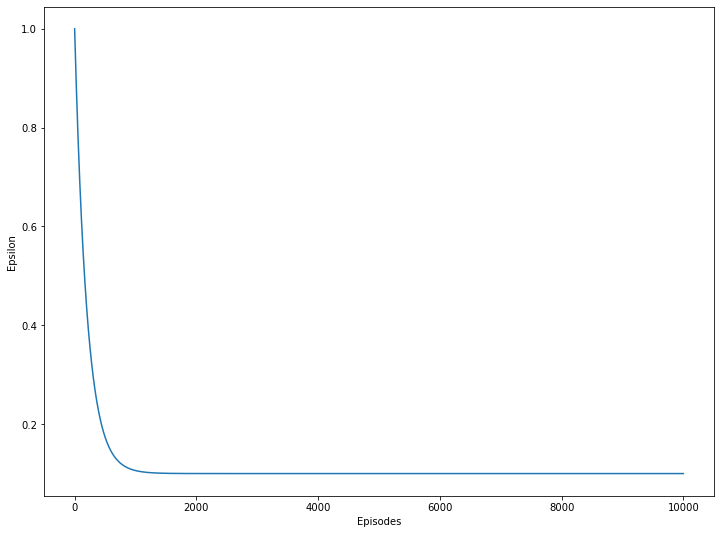

In [198]:
episode_array = np.array(range(total_episodes))
epsilon_array = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode_array)
plt.figure(figsize=(12, 9))
plt.plot(episode_array, epsilon_array)
plt.xlabel("Episodes")
plt.ylabel("Epsilon")
plt.show()

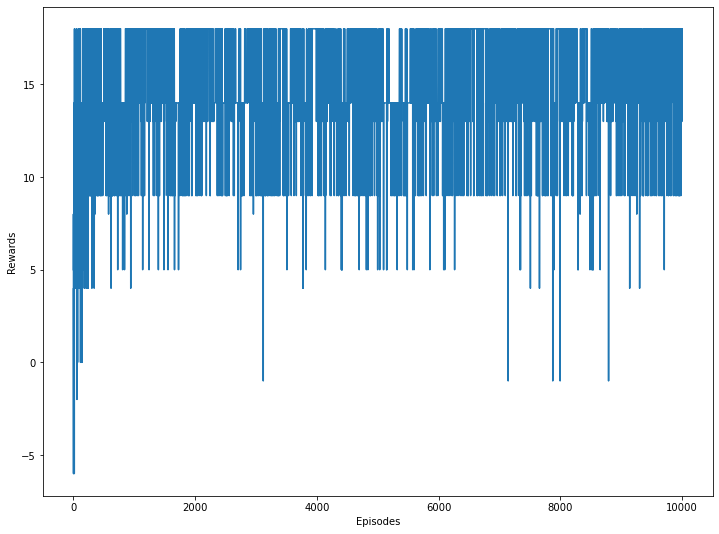

In [277]:
episode_array = np.array(range(total_episodes))
rewards_array = np.array(rewards)
plt.figure(figsize=(12, 9))
plt.plot(episode_array[:], rewards_array[:])
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()

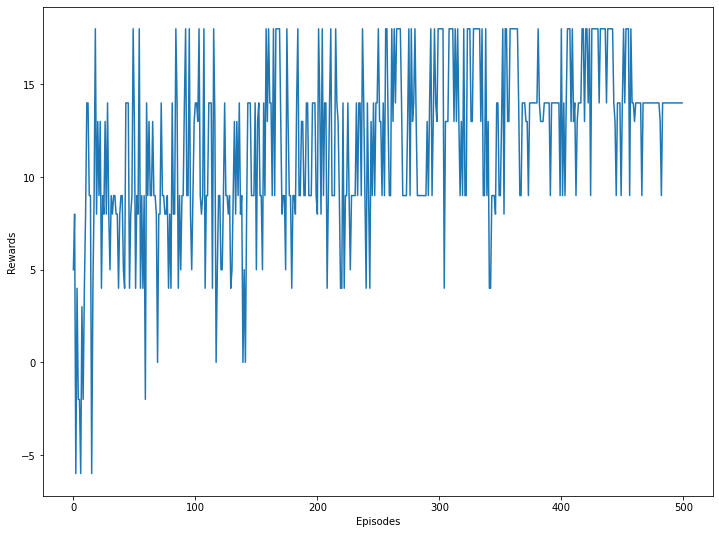

In [278]:
episode_array = np.array(range(total_episodes))
rewards_array = np.array(rewards)
plt.figure(figsize=(12, 9))
plt.plot(episode_array[:500], rewards_array[:500])
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()

## 2.1 SARSA Hyperparameter Tuning

In [10]:
min_epsilon, max_epsilon = 0.1, 1.0
total_episodes = 10000
max_steps = 100
result = []
for decay_rate in [0.005, 0.01, 0.02, 0.04]:
    for lr_rate in [0.4, 0.6, 0.8, 1.0]:
        for gamma in [0.6, 0.8, 1.0]:
            reward = SARSA_solver(min_epsilon, max_epsilon, decay_rate, total_episodes, max_steps, lr_rate, gamma)
            result.append((reward, decay_rate, lr_rate, gamma))

KeyboardInterrupt: 

In [ ]:
result.sort()

In [48]:
print(f"The best average reward is {result[-1][0]} with decay_rate={result[-1][1]}, learn rate={result[-1][2]} and gamma={result[-1][3]}")

The best average reward is 13.64 with decay_rate=0.01, learn rate=0.4 and gamma=0.8


In [73]:
min_epsilon, max_epsilon = 0.1, 1.0
decay_rate = 0.01
total_episodes = 10000
max_steps = 100
lr_rate = 0.4
gamma = 0.8
rewards = SARSA_solver(min_epsilon, max_epsilon, decay_rate, total_episodes, max_steps, lr_rate, gamma)
print(f"Average reward {sum(rewards) / len(rewards)}")

Average reward 13.7088


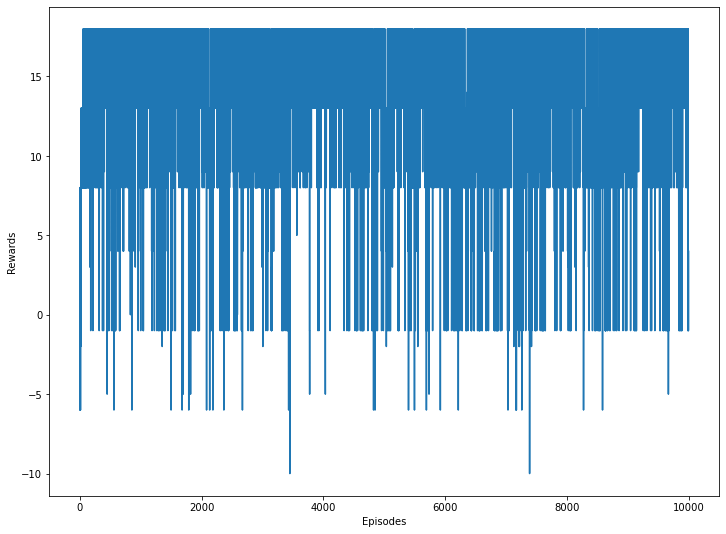

In [74]:
episode_array = np.array(range(total_episodes))
rewards_array = np.array(rewards)
plt.figure(figsize=(12, 9))
plt.plot(episode_array[:], rewards_array[:])
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()

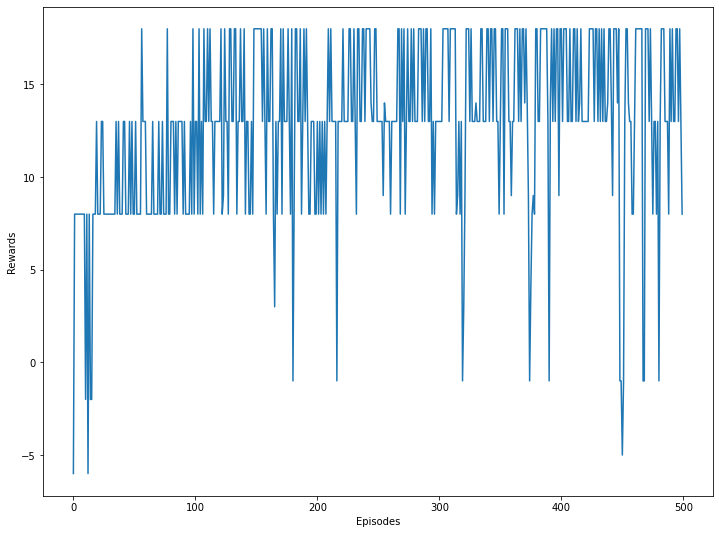

In [75]:
episode_array = np.array(range(total_episodes))
rewards_array = np.array(rewards)
plt.figure(figsize=(12, 9))
plt.plot(episode_array[:500], rewards_array[:500])
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()

# 3. Q-Learning

In [265]:
def Q_solver(min_epsilon, max_epsilon, decay_rate, total_episodes, max_steps, lr_rate, gamma):
    env = GridEnvironment()
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []
    epsilon = max_epsilon
    for episode in range(total_episodes):
        obs = env.reset()
        pos = np.where(obs == 1)[0][0]
        total_rewards = 0
        for step in range(max_steps):
            action = agent.step(obs) if np.random.uniform(0, 1) < epsilon else np.argmax(Q[pos, :])
            new_obs, reward, done, _ = env.step(action)
            new_pos = np.where(new_obs == 1)[0][0]
            Q[pos, action] = Q[pos, action] + lr_rate * (reward + gamma * np.max(Q[new_pos, :]) - Q[pos, action])        
            pos = new_pos
            total_rewards += reward
            if done:
                break
        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
        rewards.append(total_rewards)
    return rewards

In [266]:
min_epsilon, max_epsilon = 0.1, 1.0
decay_rate = 0.005
total_episodes = 10000
max_steps = 100
lr_rate = 0.81
gamma = 0.8
rewards = Q_solver(min_epsilon, max_epsilon, decay_rate, total_episodes, max_steps, lr_rate, gamma)
print(f"Average reward {sum(rewards) / len(rewards)}")

Average reward 17.1606


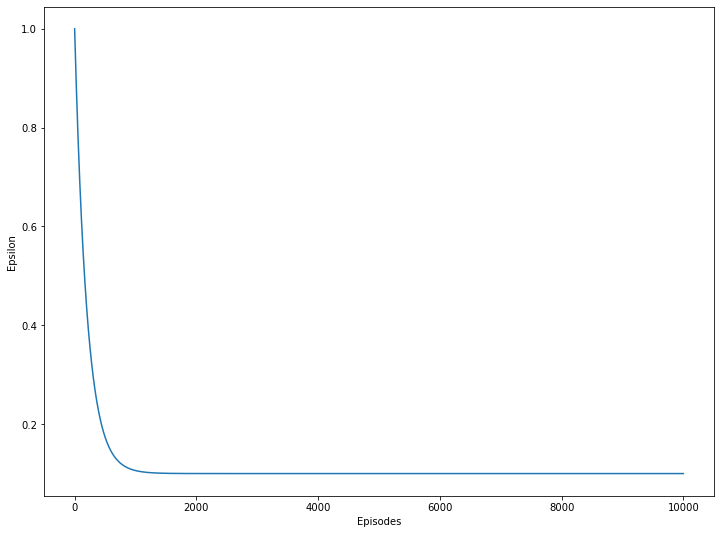

In [267]:
episode_array = np.array(range(total_episodes))
epsilon_array = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode_array)
plt.figure(figsize=(12, 9))
plt.plot(episode_array, epsilon_array)
plt.xlabel("Episodes")
plt.ylabel("Epsilon")
plt.show()

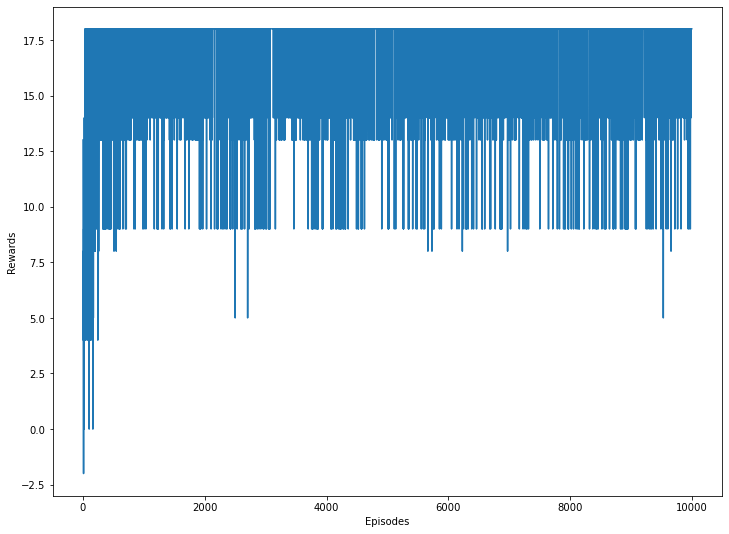

In [268]:
episode_array = np.array(range(total_episodes))
rewards_array = np.array(rewards)
plt.figure(figsize=(12, 9))
plt.plot(episode_array[:10000], rewards_array[:10000])
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()

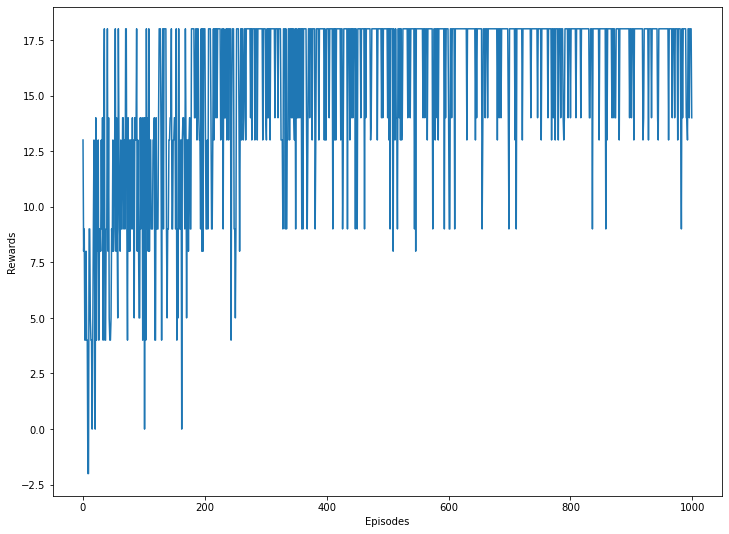

In [274]:
episode_array = np.array(range(total_episodes))
rewards_array = np.array(rewards)
plt.figure(figsize=(12, 9))
plt.plot(episode_array[:1000], rewards_array[:1000])
plt.xlabel("Episodes")
plt.ylabel("Rewards")
plt.show()